In [15]:
"""
test_xgboost_model.py

Loads trained XGBoost models and evaluates them on test data.
Performs both regression and classification predictions.
"""

import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer

# Load Test Data
CSV_FILE_PATH = "/Users/sanjojoy/Documents/MDA/data/kafka_data.csv"
df = pd.read_csv(CSV_FILE_PATH)

# Data Cleaning & Feature Engineering
df.dropna(inplace=True)

# Convert timestamp to numerical features
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["year"] = df["timestamp"].dt.year
df["month"] = df["timestamp"].dt.month
df["day"] = df["timestamp"].dt.day
df["hour"] = df["timestamp"].dt.hour
df.drop(columns=["timestamp", "user_id"], inplace=True)

# Convert "interests" from string to list
def convert_interests(value):
    try:
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        return []

df["interests"] = df["interests"].apply(convert_interests)

# Multi-label binarization for interests
mlb = MultiLabelBinarizer()
interests_encoded = pd.DataFrame(mlb.fit_transform(df["interests"]), columns=mlb.classes_)
df = df.join(interests_encoded)
df.drop(columns=["interests"], inplace=True)

# One-hot encode categorical variables
categorical_cols = ["gender", "looking_for", "children", "education_level", "occupation", "frequency_of_usage", "state"]
df = pd.get_dummies(df, columns=categorical_cols)

# Normalize numerical features
scaler = StandardScaler()
df[["age", "height"]] = scaler.fit_transform(df[["age", "height"]])

# Define test data targets and features
df["engagement_label"] = df["swiping_history"].apply(lambda x: 1 if x >= 250 else 0)
X_test = df.drop(columns=["swiping_history", "engagement_label"])
y_reg_test = df["swiping_history"]
y_clf_test = df["engagement_label"]

# Debug: verify data types
print("Data types in X_test:")
print(X_test.dtypes)



Data types in X_test:
age                    float64
height                 float64
year                     int32
month                    int32
day                      int32
                        ...   
state_Virginia            bool
state_Washington          bool
state_West Virginia       bool
state_Wisconsin           bool
state_Wyoming             bool
Length: 78, dtype: object


🔍 Regression Model Performance:
MSE: 17842.08, R²: 0.14
✅ Classification Accuracy: 69.28%
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.68      0.69      5181
           1       0.69      0.70      0.70      5129

    accuracy                           0.69     10310
   macro avg       0.69      0.69      0.69     10310
weighted avg       0.69      0.69      0.69     10310



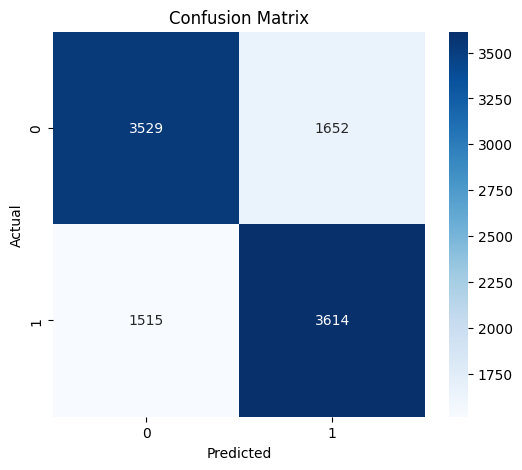

✅ Test results saved to 'test_results.csv' for visualization.


In [16]:
 #Load Trained Models
with open("/Users/sanjojoy/Documents/MDA/models/xgb_regressor.pkl", "rb") as f:
    xgb_reg = pickle.load(f)

with open("xgb_classifier.pkl", "rb") as f:
    xgb_clf = pickle.load(f)

# Regression Predictions
y_reg_pred = xgb_reg.predict(X_test)
mse = mean_squared_error(y_reg_test, y_reg_pred)
r2 = xgb_reg.score(X_test, y_reg_test)
print(f"🔍 Regression Model Performance:\nMSE: {mse:.2f}, R²: {r2:.2f}")

# Classification Predictions
y_clf_pred = xgb_clf.predict(X_test)
accuracy = accuracy_score(y_clf_test, y_clf_pred)
print(f"✅ Classification Accuracy: {accuracy:.2%}")
print("📊 Classification Report:\n", classification_report(y_clf_test, y_clf_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_clf_test, y_clf_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Create DataFrame with Predictions for Dashboard
test_results_df = df.copy()
test_results_df["predicted_swipes"] = y_reg_pred
test_results_df["predicted_engagement"] = y_clf_pred

# Save to CSV
test_results_df.to_csv("test_results.csv", index=False)
print("✅ Test results saved to 'test_results.csv' for visualization.")

In [17]:
#spark_ml_train_test

#Trains and tests Spark ML models (Random Forest for both regression and classification)
# using transformations similar to the original XGBoost + scikit-learn pipeline.

import ast
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, when, to_timestamp, year, month, dayofmonth, hour
from pyspark.sql.types import IntegerType, FloatType, ArrayType, StringType

# --- Spark ML imports ---
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, \
    IndexToString
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator


In [18]:

# 1) Initialize SparkSession
spark = SparkSession.builder \
    .appName("SparkML_Train_Test") \
    .getOrCreate()

# 2) Load CSV data into Spark DataFrame
CSV_FILE_PATH = "/Users/sanjojoy/Documents/MDA/data/kafka_data.csv"
df = spark.read.option("header", "true").csv(CSV_FILE_PATH, inferSchema=True)

# (Optional) Drop rows with nulls
df = df.na.drop()
print(f"Total rows: {df.count()}")
df.show(5)  

Total rows: 10310
+-------------------+--------------------+---+------+------+--------------------+-------------+--------+---------------+------------+---------------+------------------+------------+
|          timestamp|             user_id|age|gender|height|           interests|  looking_for|children|education_level|  occupation|swiping_history|frequency_of_usage|       state|
+-------------------+--------------------+---+------+------+--------------------+-------------+--------+---------------+------------+---------------+------------------+------------+
|2025-01-10 01:12:27|b89ed429-67c8-4c0...| 21|  Male|  6.23|         ['Reading']|     Marriage|     Yes|          Ph.D.|    Engineer|            378|             Daily|    Nebraska|
|2025-01-16 12:31:56|df6c9d4c-3b1f-41d...| 25|  Male|  5.34|['Reading', 'Movi...|Casual Dating|      No|          Ph.D.|     Teacher|            173|            Weekly|   Minnesota|
|2025-01-22 21:05:18|2a2dadc9-4213-471...| 19|  Male|   5.4|['Sports', '

In [19]:
#PREPROCESSING
# 3) Convert timestamp column into numeric features year, month, day, hour
#    (Mirroring your old approach for time-based features)
df = df.withColumn("timestamp", to_timestamp(col("timestamp")))
df = df.withColumn("year", year("timestamp"))
df = df.withColumn("month", month("timestamp"))
df = df.withColumn("day", dayofmonth("timestamp"))
df = df.withColumn("hour", hour("timestamp"))


In [20]:

# 4) Drop original timestamp, user_id
drop_cols = ["timestamp", "user_id"]
for c in drop_cols:
    if c in df.columns:
        df = df.drop(c)

# 5) Convert "interests" from string -> array
#    We'll treat it just as a string or do a simple multi-hot approach.
def parse_interests(interests_str):
    try:
        return ast.literal_eval(interests_str)
    except:
        return []
parse_interests_udf = udf(parse_interests, ArrayType(StringType()))
df = df.withColumn("interests_array", parse_interests_udf(col("interests")))

# We won't do a full multi-label pipeline here (Spark ML doesn't have a built-in multi-label binarizer).
# Instead, let's just drop the 'interests_array' for simplicity or keep it as a string column.
df = df.drop("interests")


In [21]:

# 6) Create a binary classification label: engagement_label = 1 if swiping_history >= 250 else 0
df = df.withColumn(
    "engagement_label",
    when(col("swiping_history") >= 250, 1).otherwise(0).cast(IntegerType())
)

# 7) Identify categorical columns to index + encode
categorical_cols = [
    "gender", "looking_for", "children", "education_level", "occupation",
    "frequency_of_usage", "state"
]
# Some might be null in your dataset; let's only transform those that exist
cat_cols_present = [c for c in categorical_cols if c in df.columns]

# For each categorical column, we do:
#   StringIndexer -> OneHotEncoder
indexers = [StringIndexer(inputCol=c, outputCol=c + "_idx", handleInvalid="skip")
            for c in cat_cols_present]
encoders = [OneHotEncoder(inputCols=[c + "_idx"], outputCols=[c + "_ohe"])
            for c in cat_cols_present]

# 8) Prepare numeric columns
numeric_cols = ["age", "height", "swiping_history", "year", "month", "day", "hour"]
numeric_cols_present = [c for c in numeric_cols if c in df.columns]



In [22]:
# 9) We'll assemble features for regression, ignoring the classification label
#    Then separately for classification, ignoring the regression target.
#    Actually, we can do 2 pipelines. But let's do it in a single pass:
assembler_reg = VectorAssembler(
    inputCols=[c for c in numeric_cols_present if c != "swiping_history"] + 
              [c + "_ohe" for c in cat_cols_present],
    outputCol="features_reg"
)
assembler_clf = VectorAssembler(
    inputCols=numeric_cols_present + [c + "_ohe" for c in cat_cols_present],
    outputCol="features_clf"
)

# 10) Optionally scale the numeric features
scaler_reg = StandardScaler(inputCol="features_reg", outputCol="scaledFeatures_reg", withMean=True, withStd=True)
scaler_clf = StandardScaler(inputCol="features_clf", outputCol="scaledFeatures_clf", withMean=True, withStd=True)

# 11) RandomForest for regression (predicting swiping_history)
rf_reg = RandomForestRegressor(
    featuresCol="scaledFeatures_reg",
    labelCol="swiping_history",
    predictionCol="swiping_pred",
    maxDepth=5,
    numTrees=50
)

# 12) RandomForest for classification (predicting engagement_label)
rf_clf = RandomForestClassifier(
    featuresCol="scaledFeatures_clf",
    labelCol="engagement_label",
    predictionCol="engagement_pred",
    maxDepth=5,
    numTrees=50
)


In [23]:

# 13) Build Pipelines
# Pipeline for regression
pipeline_reg = Pipeline(stages=indexers + encoders + [assembler_reg, scaler_reg, rf_reg])
# Pipeline for classification
pipeline_clf = Pipeline(stages=indexers + encoders + [assembler_clf, scaler_clf, rf_clf])

# 14) Train/test split
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# 15) Fit the regression pipeline
model_reg = pipeline_reg.fit(train_df)
pred_reg = model_reg.transform(test_df)

# 16) Evaluate regression
reg_evaluator = RegressionEvaluator(
    labelCol="swiping_history",
    predictionCol="swiping_pred",
    metricName="rmse"  # or "mse", "r2"
)
rmse = reg_evaluator.evaluate(pred_reg)
r2_evaluator = RegressionEvaluator(
    labelCol="swiping_history",
    predictionCol="swiping_pred",
    metricName="r2"
)
r2_value = r2_evaluator.evaluate(pred_reg)

print(f"Regression Metrics: RMSE={rmse:.2f}, R²={r2_value:.2f}")


ERROR:root:KeyboardInterrupt while sending command.                             
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/socket.py", line 720, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:

# 17) Fit the classification pipeline
model_clf = pipeline_clf.fit(train_df)
pred_clf = model_clf.transform(test_df)

# 18) Evaluate classification
# Evaluate accuracy
acc_eval = MulticlassClassificationEvaluator(
    labelCol="engagement_label",
    predictionCol="engagement_pred",
    metricName="accuracy"
)
accuracy = acc_eval.evaluate(pred_clf)

# Evaluate classification for f1
f1_eval = MulticlassClassificationEvaluator(
    labelCol="engagement_label",
    predictionCol="engagement_pred",
    metricName="f1"
)
f1_score = f1_eval.evaluate(pred_clf)

print(f"Classification Metrics: Accuracy={accuracy:.2%}, F1={f1_score:.2f}")


Classification Metrics: Accuracy=99.75%, F1=1.00


In [ ]:

# 19) Save predictions to a local Spark DataFrame (or Pandas) if you like
pred_clf.select("engagement_label", "engagement_pred", "probability", "scaledFeatures_clf").show(5)
pred_reg.select("swiping_history", "swiping_pred", "scaledFeatures_reg").show(5)

# 20) Convert predictions to Pandas and save CSV if you want
final_clf_pandas = pred_clf.toPandas()
final_clf_pandas.to_csv("spark_clf_results.csv", index=False)

final_reg_pandas = pred_reg.toPandas()
final_reg_pandas.to_csv("spark_reg_results.csv", index=False)

spark.stop()

+----------------+---------------+--------------------+--------------------+
|engagement_label|engagement_pred|         probability|  scaledFeatures_clf|
+----------------+---------------+--------------------+--------------------+
|               0|            0.0|[0.81960800449063...|[-1.6623405142187...|
|               1|            1.0|[0.18075063147555...|[-1.6623405142187...|
|               1|            1.0|[0.16899120747871...|[-1.6623405142187...|
|               0|            0.0|[0.81534752884569...|[-1.6623405142187...|
|               0|            0.0|[0.83910324104282...|[-1.6623405142187...|
+----------------+---------------+--------------------+--------------------+
only showing top 5 rows

+---------------+------------------+--------------------+
|swiping_history|      swiping_pred|  scaledFeatures_reg|
+---------------+------------------+--------------------+
|             41|247.86373123521562|[-1.6623405142187...|
|            387|  250.486183767695|[-1.6623405142

In [24]:
# In[1]: Import libraries
import ast
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import (col, udf, when, to_timestamp,
                                   year, month, dayofmonth, hour)
from pyspark.sql.types import (IntegerType, StringType, ArrayType)

# Spark ML
from pyspark.ml.feature import (StringIndexer, OneHotEncoder, VectorAssembler,
                                StandardScaler)
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# scikit-learn just for confusion_matrix
from sklearn.metrics import confusion_matrix



In [37]:
# In[2]: Initialize Spark Session
spark = SparkSession.builder \
    .appName("HighEngagementClassification") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

25/03/14 09:37:51 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [38]:

# In[3]: Load data
CSV_FILE_PATH = "data/kafka_data.csv"  # Update with your actual path
df = spark.read.option("header", "true").csv(CSV_FILE_PATH, inferSchema=True)


In [39]:

# In[4]: Data cleaning / transformations
# Drop rows with any null, for simplicity
df = df.na.drop()

# Convert timestamp to numeric features
df = df.withColumn("timestamp", to_timestamp(col("timestamp")))
df = df.withColumn("year", year("timestamp"))
df = df.withColumn("month", month("timestamp"))
df = df.withColumn("day", dayofmonth("timestamp"))
df = df.withColumn("hour", hour("timestamp"))

# Drop columns not needed
drop_cols = ["timestamp", "user_id"]
for c in drop_cols:
    if c in df.columns:
        df = df.drop(c)

# Convert "interests" from string -> array (optional)
def parse_interests(interests_str):
    try:
        return ast.literal_eval(interests_str)
    except:
        return []
from pyspark.sql.functions import udf
parse_udf = udf(parse_interests, ArrayType(StringType()))
df = df.withColumn("interests_array", parse_udf(col("interests"))).drop("interests")

# Create classification label: 1 if swiping_history >= 250 => "High Engagement"
df = df.withColumn("engagement_label", when(col("swiping_history") >= 250, 1).otherwise(0).cast(IntegerType()))


In [40]:

# In[5]: Identify categorical columns, numeric columns
categorical_cols = [
    "gender", "looking_for", "children", "education_level",
    "occupation", "frequency_of_usage", "state"
]
cat_cols_present = [c for c in categorical_cols if c in df.columns]

numeric_cols = ["age", "height", "swiping_history", "year", "month", "day", "hour"]
num_cols_present = [c for c in numeric_cols if c in df.columns]

# Build indexers & encoders for categoricals
indexers = [StringIndexer(inputCol=c, outputCol=c + "_idx", handleInvalid="skip")
            for c in cat_cols_present]
encoders = [OneHotEncoder(inputCols=[c + "_idx"], outputCols=[c + "_ohe"])
            for c in cat_cols_present]


In [41]:

# In[6]: Assemble features
# We'll include "swiping_history" as a feature as well, or you can exclude it if you prefer.
assembler = VectorAssembler(
    inputCols=num_cols_present + [c + "_ohe" for c in cat_cols_present],
    outputCol="features_assembled"
)

# Optionally scale numeric features
scaler = StandardScaler(
    inputCol="features_assembled",
    outputCol="scaledFeatures",
    withMean=True,
    withStd=True
)


In [42]:

# In[7]: Define a Random Forest classifier
rf_clf = RandomForestClassifier(
    featuresCol="scaledFeatures",
    labelCol="engagement_label",
    predictionCol="engagement_pred",
    maxDepth=5,
    numTrees=50
)


In [43]:

# In[8]: Build the pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler, rf_clf])


In [44]:

# In[9]: Train-test split
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

# Fit the pipeline
model = pipeline.fit(train_df)
pred = model.transform(test_df)


In [45]:

# In[10]: Evaluate
acc_eval = MulticlassClassificationEvaluator(
    labelCol="engagement_label", 
    predictionCol="engagement_pred",
    metricName="accuracy"
)
f1_eval = MulticlassClassificationEvaluator(
    labelCol="engagement_label",
    predictionCol="engagement_pred",
    metricName="f1"
)
accuracy = acc_eval.evaluate(pred)
f1_score = f1_eval.evaluate(pred)

print(f"Accuracy: {accuracy:.2%}")
print(f"F1 Score: {f1_score:.2f}")


Accuracy: 99.75%
F1 Score: 1.00


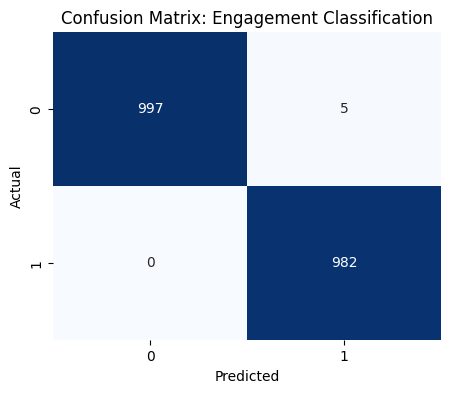

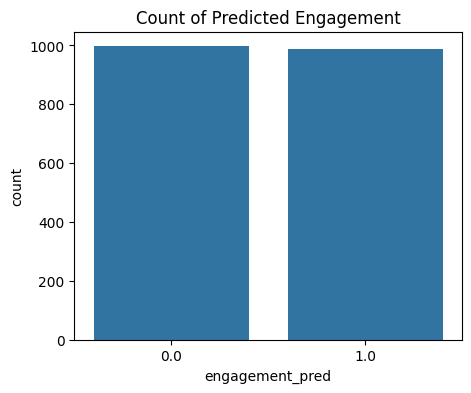

In [46]:

# In[11]: Convert to Pandas for visualization
pdf = pred.select("engagement_label", "engagement_pred").toPandas()

# Plot Confusion Matrix
cm = confusion_matrix(pdf["engagement_label"], pdf["engagement_pred"])

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix: Engagement Classification")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# If you want to see the distribution of predicted vs. actual:
# In a quick bar chart form, for example:
plt.figure(figsize=(5,4))
sns.countplot(x="engagement_pred", data=pdf)
plt.title("Count of Predicted Engagement")
plt.show()

# (Optional) If you'd like to see probability distribution, you can do:
# pred.select("probability").show(5)


In [ ]:

# In[12]: Cleanup
spark.stop()

In [ ]:
# In[1]: Necessary Imports
import ast
import matplotlib.pyplot as plt
import seaborn as sns

# PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, udf, when, to_timestamp, year, month, dayofmonth, hour
)
from pyspark.sql.types import (
    IntegerType, StringType, ArrayType
)

# Spark ML
from pyspark.ml.feature import (
    StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
)
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# For confusion matrix plotting
from sklearn.metrics import confusion_matrix

# In[2]: Create Spark Session
spark = (SparkSession.builder
    .appName("UsageFrequencyPrediction")
    .master("local[4]")
    .config("spark.driver.memory", "4g")
    .getOrCreate())

# In[3]: Load the dataset
CSV_FILE_PATH = "/Users/sanjojoy/Documents/MDA/data/kafka_data.csv"
df = (spark.read
      .option("header", "true")
      .csv(CSV_FILE_PATH, inferSchema=True))

# Discard rows containing nulls
df = df.na.drop()

# In[4]: Feature Engineering
# 1) Convert timestamps to numeric time features (year, month, day, hour)
df = df.withColumn("timestamp", to_timestamp(col("timestamp")))
df = df.withColumn("year", year("timestamp"))
df = df.withColumn("month", month("timestamp"))
df = df.withColumn("day", dayofmonth("timestamp"))
df = df.withColumn("hour", hour("timestamp"))

# 2) Drop columns not needed
drop_cols = ["timestamp", "user_id"]
for col_name in drop_cols:
    if col_name in df.columns:
        df = df.drop(col_name)

# 3) Convert interests from string to an array (optional)
def parse_interests(s):
    try:
        return ast.literal_eval(s)
    except:
        return []
parse_udf = udf(parse_interests, ArrayType(StringType()))
df = df.withColumn("interests_array", parse_udf(col("interests"))).drop("interests")

# In[5]: Rename the usage frequency column to 'usage_freq'
# (Original: 'frequency_of_usage' => 'usage_freq')
df = df.withColumnRenamed("frequency_of_usage", "usage_freq")

# (Optional) Check distinct usage frequency values
df.select("usage_freq").distinct().show()

# In[6]: Identify categorical/numerical columns
categorical_cols = [
    "gender", "looking_for", "children", "education_level",
    "occupation", "state"
]
numeric_cols = ["age", "height", "swiping_history", "year", "month", "day", "hour"]

# Filter columns that actually exist
cat_cols_present = [c for c in categorical_cols if c in df.columns]
num_cols_present = [c for c in numeric_cols if c in df.columns]

# StringIndex + OneHotEncode for each categorical column
indexers = [
    StringIndexer(inputCol=c, outputCol=f"{c}_idx", handleInvalid="skip")
    for c in cat_cols_present
]
encoders = [
    OneHotEncoder(inputCols=[f"{c}_idx"], outputCols=[f"{c}_ohe"])
    for c in cat_cols_present
]

# For the label column: usage_freq
freq_indexer = StringIndexer(
    inputCol="usage_freq",
    outputCol="usage_freq_idx",
    handleInvalid="skip"
)

# In[7]: Assemble features and scale them
assembler = VectorAssembler(
    inputCols=[*num_cols_present, *(f"{c}_ohe" for c in cat_cols_present)],
    outputCol="features_assembled"
)
scaler = StandardScaler(
    inputCol="features_assembled",
    outputCol="scaledFeatures",
    withMean=True,
    withStd=True
)

# In[8]: Define the RandomForest classifier
rf_clf = RandomForestClassifier(
    featuresCol="scaledFeatures",
    labelCol="usage_freq_idx",
    predictionCol="usage_freq_pred",
    maxDepth=5,
    numTrees=40
)

# In[9]: Build a pipeline combining all transformations + classifier
pipeline = Pipeline(stages=[
    *indexers,
    *encoders,
    freq_indexer,
    assembler,
    scaler,
    rf_clf
])

# In[10]: Train/Test Split, then train
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train_df)

# Generate predictions
pred = model.transform(test_df)

# In[11]: Evaluate multi-class classification
acc_eval = MulticlassClassificationEvaluator(
    labelCol="usage_freq_idx",
    predictionCol="usage_freq_pred",
    metricName="accuracy"
)
accuracy = acc_eval.evaluate(pred)

f1_eval = MulticlassClassificationEvaluator(
    labelCol="usage_freq_idx",
    predictionCol="usage_freq_pred",
    metricName="f1"
)
f1_score = f1_eval.evaluate(pred)

print(f"Usage Frequency Classification - Accuracy: {accuracy:.2%}")
print(f"Usage Frequency Classification - F1 Score: {f1_score:.2f}")

# In[12]: Convert predictions to Pandas for confusion matrix
pdf = pred.select("usage_freq_idx", "usage_freq_pred").toPandas()

# Retrieve the StringIndexer stage for usage_freq
indexer_model = None
for stage in model.stages:
    if isinstance(stage, StringIndexer) and stage.getOutputCol() == "usage_freq_idx":
        indexer_model = stage
        break

if indexer_model is not None:
    labels = indexer_model.labels  # e.g. ["Daily", "Weekly", "Monthly"]
    # Convert numeric predictions back to string
    pdf["actual_freq"] = pdf["usage_freq_idx"].apply(lambda x: labels[int(x)])
    pdf["predicted_freq"] = pdf["usage_freq_pred"].apply(lambda x: labels[int(x)])
else:
    # Fallback if not found
    pdf["actual_freq"] = pdf["usage_freq_idx"]
    pdf["predicted_freq"] = pdf["usage_freq_pred"]
    labels = pdf["actual_freq"].unique().tolist()

# In[13]: Confusion Matrix
cm = confusion_matrix(pdf["actual_freq"], pdf["predicted_freq"], labels=labels)

plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues", cbar=False,
    xticklabels=labels, yticklabels=labels
)
plt.title("Confusion Matrix: Usage Frequency")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# (Optional) Plot distribution of predicted usage frequency
plt.figure(figsize=(5, 3))
sns.countplot(x="predicted_freq", data=pdf)
plt.title("Predicted Usage Frequency Distribution")
plt.show()

# In[14]: Stop Spark
spark.stop()

+------------------+
|frequency_of_usage|
+------------------+
|           Monthly|
|             Daily|
|            Weekly|
+------------------+

Usage Frequency Classification - Accuracy: 49.65%
Usage Frequency Classification - F1 Score: 0.33


NameError: name 'labels' is not defined